In [12]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [10]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return [
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ]

def plot_imu_data(filename):
    try:
        with open(filename, 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            data = list(reader)
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    vehicles = defaultdict(list)
    for row in data:
        vehicle = row['VehicleName']
        if vehicle.startswith('Drone'):
            try:
                time = float(row['TimeStamp']) / 1000.0  # converting ms to seconds
                pos = [float(row['POS_X']), float(row['POS_Y']), float(row['POS_Z'])]
                quat = [float(row['Q_W']), float(row['Q_X']), float(row['Q_Y']), float(row['Q_Z'])]
                vehicles[vehicle].append({'time': time, 'pos': pos, 'quat': quat})
            except KeyError as e:
                print(f"Missing column {e} in row: {row}")
                return
            except ValueError as e:
                print(f"Invalid data format in row: {row}")
                return

    if not vehicles:
        print("No drones found in the data (vehicles must start with 'Drone').")
        return

    
    for vehicle, records in vehicles.items():
        if len(records) < 2:
            print(f"Vehicle {vehicle} has only one data point, cannot calculate derivatives.")
            continue

        records.sort(key=lambda x: x['time']) # sorting records by time
        
        times = np.array([r['time'] for r in records])
        pos_x = np.array([r['pos'][0] for r in records])
        pos_y = np.array([r['pos'][1] for r in records])
        pos_z = np.array([r['pos'][2] for r in records])
        quats = np.array([r['quat'] for r in records])

        # calculating velocity using numpy.gradient
        vel_x = np.gradient(pos_x, times)
        vel_y = np.gradient(pos_y, times)
        vel_z = np.gradient(pos_z, times)

        # calculating acceleration
        acc_x = np.gradient(vel_x, times)
        acc_y = np.gradient(vel_y, times)
        acc_z = np.gradient(vel_z, times)

        # calculating angular velocity from quaternion differences
        omega_x, omega_y, omega_z = [], [], []
        for i in range(len(times) - 1):
            q1 = quats[i]
            q2 = quats[i + 1]
            q1_conj = [q1[0], -q1[1], -q1[2], -q1[3]]
            q_rel = quaternion_multiply(q2, q1_conj)
            dt = times[i + 1] - times[i]
            omega_x.append(2 * q_rel[1] / dt)
            omega_y.append(2 * q_rel[2] / dt)
            omega_z.append(2 * q_rel[3] / dt)

        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        fig.suptitle(f'IMU Data for {vehicle}')

        axs[0].plot(times, pos_x, label='X', color='blue')
        axs[0].plot(times, pos_y, label='Y', color='red')
        axs[0].plot(times, pos_z, label='Z', color='green')
        axs[0].set_title('Position')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Position (m)')
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(times, vel_x, label='Vx', color='blue')
        axs[1].plot(times, vel_y, label='Vy', color='red')
        axs[1].plot(times, vel_z, label='Vz', color='green')
        axs[1].set_title('Velocity')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Velocity (m/s)')
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(times, acc_x, label='Ax', color='blue')
        axs[2].plot(times, acc_y, label='Ay', color='red')
        axs[2].plot(times, acc_z, label='Az', color='green')
        axs[2].set_title('Acceleration')
        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('Acceleration (m/s²)')
        axs[2].legend()
        axs[2].grid(True)

        # Plot Angular Velocity
        if len(omega_x) > 0:
            axs[3].plot(times[1:], omega_x, label='Wx', color='blue')
            axs[3].plot(times[1:], omega_y, label='Wy', color='red')
            axs[3].plot(times[1:], omega_z, label='Wz', color='green')
            axs[3].set_title('Angular Velocity')
            axs[3].set_xlabel('Time (s)')
            axs[3].set_ylabel('Angular Velocity (rad/s)')
            axs[3].legend()
            axs[3].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

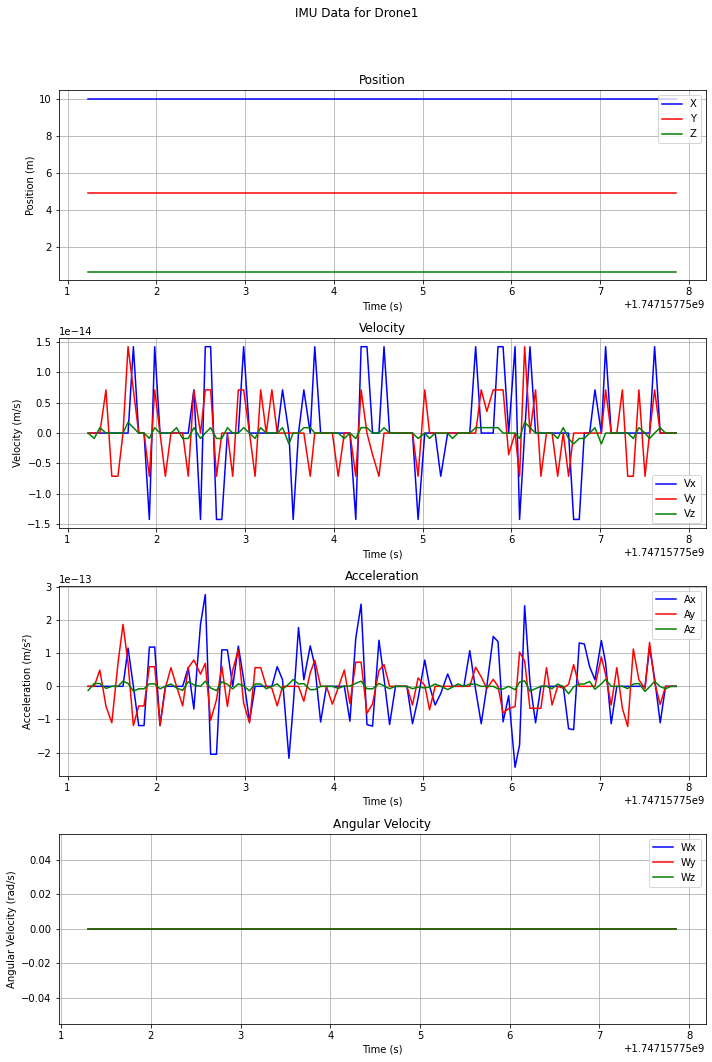

In [11]:
plot_imu_data('airsim_rec.txt')